# Part 1

In [15]:
import random
import numpy
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Generate Distribution Functions

In [16]:
def sorted_indexes(payoffs):
    vals_indexes=[]
    ind_by_val = []

    for i in range(len(payoffs)):
        vals_indexes.append([payoffs[i],i])
    
    vals_indexes.sort(reverse=True)
    for x in vals_indexes:
        ind_by_val.append(x[1])
    return ind_by_val

def find_min_index(payoffs):
    min_value = min(payoffs)
    min_index = payoffs.index(min_value)
    return min_index


def generate_adversarial_payoffs(num_actions, num_rounds):
    rounds_list = []
    totals_by_round = []
    initial_payoff = round(random.random(), 2)
    first_payoffs = [0 for i in range(num_actions)]
    first_payoffs[random.randrange(num_actions)] = initial_payoff
    total_payoffs = [first_payoffs[i] for i in range(num_actions)]
    min_index = find_min_index(total_payoffs)
    rounds_list.append(first_payoffs)
    totals_by_round.append([total_payoffs[i] for i in range(num_actions)])
    
    for i in range(num_rounds - 1):
        new_payoff = round(random.random(), 2)
        adversarial_payoffs = [0 for i in range(num_actions)]
        adversarial_payoffs[min_index] = new_payoff
        for i in range(num_actions):
            total_payoffs[i] += adversarial_payoffs[i]
            total_payoffs[i] = round(total_payoffs[i], 2)
        
        min_index = find_min_index(total_payoffs)
        new_totals = [total_payoffs[i] for i in range(num_actions)]
        totals_by_round.append(new_totals)
        rounds_list.append(adversarial_payoffs)

    #print("utility at each round: \n", rounds_list)
    #print("totals by round: \n", totals_by_round)
    #print("final payoffs: \n", total_payoffs)
    return rounds_list, totals_by_round


#generate_adversarial_payoffs(10, 10)

In [17]:
#when generating the bernoulli payoffs, generate the payoffs of each action at each round and the 
#total payoffs up to that point for each action. i.e. list of lists of payoffs/round & list of lists of aggregated payoffs.
#uncomment the last line of the generate_adversarial_payoffs section for an example
def find_payoff(success_chance):
    comparison_val = random.random()
    return int(success_chance > comparison_val)

def generate_bernoulli_payoffs(num_actions, num_rounds):
    rounds_list = []
    totals_by_round = []
    total_payoffs = [0 for i in range(num_actions)]
    totals_by_round = []
    action_success_chances = [round(random.random() / 2,2) for i in range(num_actions)]
    
    for i in range(num_rounds):
        new_payoffs = [find_payoff(action_success_chances[j]) for j in range(num_actions)]
        
        for i in range(num_actions):
            total_payoffs[i] += new_payoffs[i]
            total_payoffs[i] = round(total_payoffs[i], 2)
        
        new_totals = [total_payoffs[i] for i in range(num_actions)]
        totals_by_round.append(new_totals)
        rounds_list.append(new_payoffs)

    #print("utility at each round: \n", rounds_list)
    #print("totals by round: \n", totals_by_round)
    #print("final payoffs: \n", total_payoffs)
    return rounds_list, totals_by_round

#generate_bernoulli_payoffs(3, 3)



In [42]:
def rotate_action_payoffs(action_payoffs):
    copy_payoffs = [action_payoffs[i] for i in range(len(action_payoffs))]
    for i in range(0, len(action_payoffs)):
        action_payoffs[i] = copy_payoffs[i-1]
    return action_payoffs

def generate_rotational_random_payoffs(num_actions, num_rounds):
    rounds_list = []
    totals_by_round = []
    action_payoffs = [round(random.random(), 2) for i in range(num_actions)]
    max_index = action_payoffs.index(max(action_payoffs))
    secondary_max_index = max_index - 1
    max_payoff = action_payoffs[max_index]
    if max_index == 0:
        action_payoffs[-1] = 0
    else:
        action_payoffs[max_index - 1] = 0
    total_payoffs = [0 for i in range(num_actions)]
    action_payoffs = [0 for i in range(num_actions)]
    action_payoffs[max_index] = max_payoff
    
    for i in range(num_rounds):
        #if random.random() > 0.9:
        #action_payoffs = rotate_action_payoffs(action_payoffs)
        action_payoffs[max_index], action_payoffs[secondary_max_index] = action_payoffs[secondary_max_index], action_payoffs[max_index]
            
        for i in range(num_actions):
            total_payoffs[i] += action_payoffs[i]
            total_payoffs[i] = round(total_payoffs[i], 2)
        new_totals = [total_payoffs[i] for i in range(num_actions)]    
        rounds_list.append([action_payoffs[i] for i in range(num_actions)])
        totals_by_round.append(new_totals)
        
    return rounds_list, totals_by_round


## Simulate Algorithm Behavior Functions

In [43]:
def simulate_exponential_weights(rounds_list, totals_by_round, epsilon, max_payoff):
    num_rounds = len(rounds_list)
    num_actions = len(rounds_list[0])
    choices_made = []
    action_weights = []
    action_probabilities = [(1/num_actions) for i in range(num_actions)]
    current_weights = [1 for i in range(num_actions)]
    action_weights.append(current_weights)
    alg_payoffs = []
    opt_payoffs = []
    
    for round in range(1, num_rounds):
        last_round = round - 1
        current_weights = [None for i in range(num_actions)]
        for action in range(num_actions):
            V_last = totals_by_round[last_round][action]
            exp = V_last / max_payoff
            current_weights[action] = pow(1 + epsilon, exp)
        #randomly select from actions using weights as probabilities
        selected_payoff = random.choices(rounds_list[round], weights=current_weights, k=1)[0]
        alg_payoffs.append(selected_payoff)  
        opt_payoffs.append(max(rounds_list[round]))
        action_weights.append(current_weights)
        
    return alg_payoffs, totals_by_round, opt_payoffs

## Regret Visual Analysis Function

In [44]:
def visualize_regret(avg_regret_per_round, rounds, learning_rates, plot_title, file_name):
    
    add_str = ''
    for i in range(len(learning_rates)):
        if i == 3: 
            each_lr = round(learning_rates[i], 2)
            add_str = '(theor opt learn rate)'
        else: 
            each_lr = learning_rates[i]
            add_str = ''
        #print(each_lr)
        x = np.array(list(range(1, rounds)))
        y = np.array(avg_regret_per_round[learning_rates[i]])
        plt.plot(x, y, label='learning rate = {each_lr} {add_str}'.format(each_lr=each_lr, add_str = add_str), linewidth=1)
    plt.xlabel("Round")
    plt.ylabel("Regret")
    plt.title(plot_title)
    plt.legend(loc='best', prop={'size': 7})
    
    plt.savefig(file_name)

    plt.show()

## Monte Carlo Trials

- Declare size of inputs
- Generate payoffs
- For each learning rate $\{\epsilon_1, . . ., \epsilon_n\}$
    - For each input
        - Simulate the algorithm
        - calculate OPT (best in hindsight payoff)
        - calculate the algorithm's regret
    - Calculate the average regret for this learning rate $\epsilon$

In [45]:
def sum_to_round_i(alg_payoffs, current_round):
    total = 0
    for i in range(current_round):
        total += alg_payoffs[i]
    return total

def individual_regrets(alg_payoffs, round_totals):
    final_payoffs = round_totals[-1]
    opt_action = final_payoffs.index(max(final_payoffs))
    #print(opt_action)
    individual_regrets = [0 for i in range(len(alg_payoffs))]
    for round in range((len(alg_payoffs))):
        individual_regrets[round] = (round_totals[round][opt_action] - sum_to_round_i(alg_payoffs, round)) / (round + 1)
    return individual_regrets

In [46]:
rounds = 100
actions = 5
N = 1000
# ADD OPTIMAL LEARNING RATE EPSILON
opt_lr_eps = math.sqrt(numpy.log(actions)/rounds)
learning_rates = [0, 0.25, 0.5, opt_lr_eps, 0.75, 1, 100]

In [47]:
#adversarial monte carlo trial
max_payoff = 1
avg_lr_payoffs = dict()
all_opt_payoffs = []
avg_regret_per_round = dict()
avg_regret_per_round_1 = dict()
for n in range(N):
    adversarial_payoffs, adversarial_totals = generate_adversarial_payoffs(actions, rounds)
    for epsilon in learning_rates:
        adv_payoffs, adv_round_totals, adv_opt = simulate_exponential_weights(adversarial_payoffs, adversarial_totals, epsilon, max_payoff)
        adv_regrets = individual_regrets(adv_payoffs, adv_round_totals)
        adv_avg_regrets = sum(adv_regrets) / len(adv_regrets)
        adv_final_regret = adv_regrets[-1]
        adv_regrets_1 = []
        for i in range(len(adv_payoffs)):
            adv_regrets_1.append(adv_opt[i] - adv_payoffs[i])
        
        if epsilon not in avg_regret_per_round_1:
            avg_regret_per_round_1[epsilon] = adv_regrets_1
        else:
            for i in range(len(avg_regret_per_round_1[epsilon])):
                avg_regret_per_round_1[epsilon][i] = ((n * avg_regret_per_round_1[epsilon][i]) + adv_regrets_1[i]) / (n + 1)
                
        if epsilon not in avg_regret_per_round:
            avg_regret_per_round[epsilon] = adv_regrets
        else:
            for i in range(len(avg_regret_per_round[epsilon])):
                avg_regret_per_round[epsilon][i] = ((n * avg_regret_per_round[epsilon][i]) + adv_regrets[i]) / (n + 1)            
        
        if epsilon not in avg_lr_payoffs:
            avg_lr_payoffs[epsilon] = [sum(adv_payoffs)]
        else:
            avg_lr_payoffs[epsilon].append(sum(adv_payoffs))
    all_opt_payoffs.append(max(adv_round_totals[-1]))
for key, val in avg_regret_per_round.items():
    print("Average ALG regret for epsilon =", key, "on adversarial distribution =", val[-1])

for key, val in avg_lr_payoffs.items():
    print("Average ALG payoff for epsilon =", key, "on adversarial distribution =", sum(val) / len(val))
print("Average OPT payoff for adversarial distribution =", sum(all_opt_payoffs) / len(all_opt_payoffs))  

Average ALG regret for epsilon = 0 on adversarial distribution = 0.0013477777777777772
Average ALG regret for epsilon = 0.25 on adversarial distribution = 0.008551212121212114
Average ALG regret for epsilon = 0.5 on adversarial distribution = 0.012724545454545466
Average ALG regret for epsilon = 0.12686362411795196 on adversarial distribution = 0.00524161616161616
Average ALG regret for epsilon = 0.75 on adversarial distribution = 0.0171550505050505
Average ALG regret for epsilon = 1 on adversarial distribution = 0.019301313131313145
Average ALG regret for epsilon = 100 on adversarial distribution = 0.08048515151515155
Average ALG payoff for epsilon = 0 on adversarial distribution = 10.020390000000011
Average ALG payoff for epsilon = 0.25 on adversarial distribution = 9.317450000000001
Average ALG payoff for epsilon = 0.5 on adversarial distribution = 8.90606999999999
Average ALG payoff for epsilon = 0.12686362411795196 on adversarial distribution = 9.640360000000003
Average ALG payoff

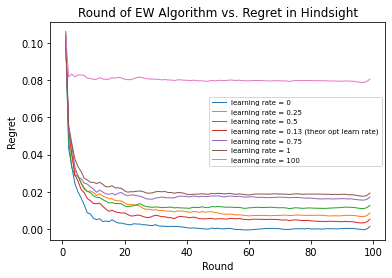

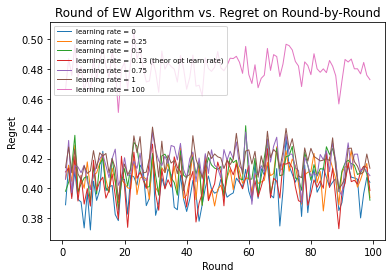

In [48]:
visualize_regret(avg_regret_per_round, rounds, learning_rates,'Round of EW Algorithm vs. Regret in Hindsight','adv_plot_1.png')
visualize_regret(avg_regret_per_round_1, rounds, learning_rates, 'Round of EW Algorithm vs. Regret on Round-by-Round', 'adv_plot_2.png')

In [49]:
#bernoulli monte carlo trial
max_payoff = 1
avg_lr_payoffs = dict()
all_opt_payoffs = []
avg_regret_per_round = dict()
avg_regret_per_round_1 = dict()

for n in range(N):
    bernoulli_payoffs, bernoulli_totals = generate_bernoulli_payoffs(actions, rounds)
    for epsilon in learning_rates:
        bern_payoffs, bern_round_totals, bern_opt = simulate_exponential_weights(bernoulli_payoffs, bernoulli_totals, epsilon, max_payoff)
        bern_regrets = individual_regrets(bern_payoffs, bern_round_totals)
        bern_avg_regrets = sum(bern_regrets) / len(bern_regrets)
        bern_final_regret = bern_regrets[-1]
        bern_regrets_1 = []
        for i in range(len(adv_payoffs)):
            bern_regrets_1.append(bern_opt[i] - bern_payoffs[i])
        
        if epsilon not in avg_regret_per_round_1:
            avg_regret_per_round_1[epsilon] = bern_regrets_1
        else:
            for i in range(len(avg_regret_per_round_1[epsilon])):
                avg_regret_per_round_1[epsilon][i] = ((n * avg_regret_per_round_1[epsilon][i]) + bern_regrets_1[i]) / (n + 1)
        
        if epsilon not in avg_regret_per_round:
            avg_regret_per_round[epsilon] = bern_regrets
        else:
            for i in range(len(avg_regret_per_round[epsilon])):
                avg_regret_per_round[epsilon][i] = ((n * avg_regret_per_round[epsilon][i]) + bern_regrets[i]) / (n + 1)
        
        if epsilon not in avg_lr_payoffs:
            avg_lr_payoffs[epsilon] = [sum(bern_payoffs)]
        else:
            avg_lr_payoffs[epsilon].append(sum(bern_payoffs))
    
    all_opt_payoffs.append(max(bern_round_totals[-1]))
for key, val in avg_regret_per_round.items():
    print("Average ALG regret for epsilon =", key, "on bernoulli distribution =", val[-1])
for key, val in avg_lr_payoffs.items():
    print("Average ALG payoff for epsilon =", key, "on bernoulli distribution =", sum(val) / len(val))
print("Average OPT payoff for bernoulli distribution =", sum(all_opt_payoffs) / len(all_opt_payoffs) )

Average ALG regret for epsilon = 0 on bernoulli distribution = 0.1828585858585882
Average ALG regret for epsilon = 0.25 on bernoulli distribution = 0.07678787878787992
Average ALG regret for epsilon = 0.5 on bernoulli distribution = 0.05709090909090988
Average ALG regret for epsilon = 0.12686362411795196 on bernoulli distribution = 0.1037979797979812
Average ALG regret for epsilon = 0.75 on bernoulli distribution = 0.04915151515151578
Average ALG regret for epsilon = 1 on bernoulli distribution = 0.046141414141414774
Average ALG regret for epsilon = 100 on bernoulli distribution = 0.03474747474747523
Average ALG payoff for epsilon = 0 on bernoulli distribution = 24.444
Average ALG payoff for epsilon = 0.25 on bernoulli distribution = 35.099
Average ALG payoff for epsilon = 0.5 on bernoulli distribution = 37.066
Average ALG payoff for epsilon = 0.12686362411795196 on bernoulli distribution = 32.401
Average ALG payoff for epsilon = 0.75 on bernoulli distribution = 37.833
Average ALG payo

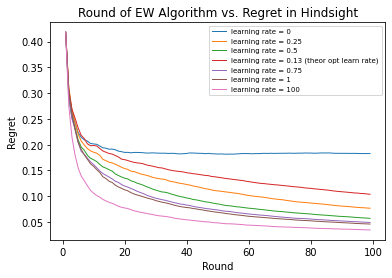

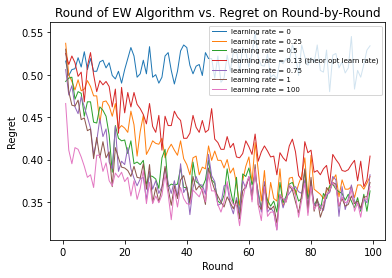

In [50]:
visualize_regret(avg_regret_per_round, rounds, learning_rates, 'Round of EW Algorithm vs. Regret in Hindsight', 'bern_plot_1.png')
visualize_regret(avg_regret_per_round_1, rounds, learning_rates, 'Round of EW Algorithm vs. Regret on Round-by-Round', 'bern_plot_2.png')

In [51]:
# rotational generation monte carlo trial
generate_rotational_random_payoffs
max_payoff = 1
avg_lr_payoffs = dict()
all_opt_payoffs = []
avg_regret_per_round = dict()
for n in range(N):
    rotational_payoffs, rotational_totals = generate_rotational_random_payoffs(actions, rounds)
    for epsilon in learning_rates:
        rot_payoffs, rot_round_totals, rot_opt = simulate_exponential_weights(rotational_payoffs, rotational_totals, epsilon, max_payoff)
        rot_regrets = individual_regrets(rot_payoffs, rot_round_totals)
        rot_avg_regrets = sum(rot_regrets) / len(rot_regrets)
        rot_final_regret = rot_regrets[-1]
        if epsilon not in avg_regret_per_round:
            avg_regret_per_round[epsilon] = rot_regrets
        else:
            for i in range(len(avg_regret_per_round[epsilon])):
                avg_regret_per_round[epsilon][i] = ((n * avg_regret_per_round[epsilon][i]) + rot_regrets[i]) / (n + 1)
                
        rot_regrets_1 = []
        for i in range(len(adv_payoffs)):
            rot_regrets_1.append(rot_opt[i] - rot_payoffs[i])
        
        if epsilon not in avg_regret_per_round_1:
            avg_regret_per_round_1[epsilon] = rot_regrets_1
        else:
            for i in range(len(avg_regret_per_round_1[epsilon])):
                avg_regret_per_round_1[epsilon][i] = ((n * avg_regret_per_round_1[epsilon][i]) + rot_regrets_1[i]) / (n + 1)
        
        if epsilon not in avg_lr_payoffs:
            avg_lr_payoffs[epsilon] = [sum(rot_payoffs)]
        else:
            avg_lr_payoffs[epsilon].append(sum(rot_payoffs))
    
    all_opt_payoffs.append(max(rot_round_totals[-1]))
for key, val in avg_regret_per_round.items():
    print("Average ALG regret for epsilon =", key, "on rotational random distribution =", val[-1])
for key, val in avg_lr_payoffs.items():
    print("Average ALG payoff for epsilon =", key, "on rotational random distribution =", sum(val) / len(val))
print("Average OPT payoff for rotational random distribution =", sum(all_opt_payoffs) / len(all_opt_payoffs) )


Average ALG regret for epsilon = 0 on rotational random distribution = 0.3370422222222219
Average ALG regret for epsilon = 0.25 on rotational random distribution = 0.03940909090909093
Average ALG regret for epsilon = 0.5 on rotational random distribution = 0.02360070707070712
Average ALG regret for epsilon = 0.12686362411795196 on rotational random distribution = 0.06784525252525261
Average ALG regret for epsilon = 0.75 on rotational random distribution = 0.019056464646464696
Average ALG regret for epsilon = 1 on rotational random distribution = 0.016160909090909146
Average ALG regret for epsilon = 100 on rotational random distribution = 0.00702828282828288
Average ALG payoff for epsilon = 0 on rotational random distribution = 17.25026999999999
Average ALG payoff for epsilon = 0.25 on rotational random distribution = 47.05079999999999
Average ALG payoff for epsilon = 0.5 on rotational random distribution = 48.61583000000002
Average ALG payoff for epsilon = 0.12686362411795196 on rotati

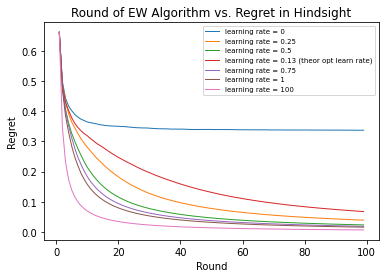

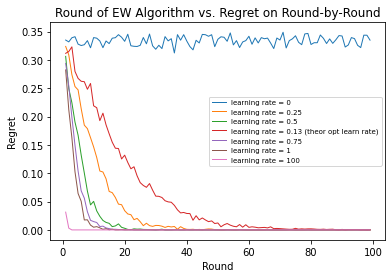

In [52]:
visualize_regret(avg_regret_per_round, rounds, learning_rates, 'Round of EW Algorithm vs. Regret in Hindsight', 'rot_plot_1.png')
visualize_regret(avg_regret_per_round_1, rounds, learning_rates, 'Round of EW Algorithm vs. Regret on Round-by-Round', 'rot_plot_2.png')


# Part 2C. Data in the wild

## Data Cleaning 

In [16]:
#Stock dataset taken from https://www.kaggle.com/datasets/camnugent/sandp500?select=all_stocks_5yr.csv

df = pd.read_csv('all_stocks_5yr.csv') 

df = df.query('date.str.startswith("2017")', 
engine="python")

# resetting index
df.reset_index(inplace = True)

df['Day']=df.groupby(['Name']).cumcount()+1

#Add payoffs of each stock each day as column 

df['payoff'] = np.where(df['close'] / df['open'] >= 1, 1, 0)

#get the number of total stocks
df.drop_duplicates(subset = ["Name"]).shape[0]

#get the number of total stocks
df.drop_duplicates(subset = ["Name"]).shape[0]

#Max payoff value

df['payoff'].max()

#query stocks by date or day
df[df['Day'] == 1]

df

#identify stocks that do not have full year stock prices data

temp = df[df['Day'] == 1]
temp = temp['Name'].tolist()

temp_2 = df[df['Day'] == 251]
temp_2 = temp_2['Name'].tolist()

print('Stocks that do not have data for all dates throughout the year: ', ','.join(set(temp).difference(temp_2)))

#drop outlier stocks with not enough data

df = df.drop(df[df.Name == 'BHF'].index)
df = df.drop(df[df.Name == 'DXC'].index) 
df = df.drop(df[df.Name == 'HLT'].index) 
df = df.drop(df[df.Name == 'APTV'].index) 
df = df.drop(df[df.Name == 'DWDP'].index) 
df = df.drop(df[df.Name == 'BHGE'].index) 

df 

Stocks that do not have data for all dates throughout the year:  BHGE,BHF,DXC,DWDP,APTV,HLT


index        date   open    high     low  close   volume Name  Day  \
0          982  2017-01-03  47.28  47.340  46.135  46.30  6737752  AAL    1   
1          983  2017-01-04  46.63  47.435  46.350  46.70  5859604  AAL    2   
2          984  2017-01-05  46.52  46.930  45.610  45.89  6825316  AAL    3   
3          985  2017-01-06  45.85  46.720  45.470  46.21  7260197  AAL    4   
4          986  2017-01-09  46.01  47.340  45.780  47.08  4739142  AAL    5   
...        ...         ...    ...     ...     ...    ...      ...  ...  ...   
126027  619009  2017-12-22  72.30  72.370  71.790  71.99  1345683  ZTS  247   
126028  619010  2017-12-26  72.40  72.550  71.900  72.34   792134  ZTS  248   
126029  619011  2017-12-27  72.59  72.690  72.250  72.45  1159771  ZTS  249   
126030  619012  2017-12-28  72.49  72.600  72.140  72.39   710499  ZTS  250   
126031  619013  2017-12-29  72.55  72.760  72.040  72.04  1704122  ZTS  251   

        payoff  
0            0  
1            1  
2            0  
3            1  
4            1  
...        ...  
126027       0  
126028       0  
126029       0  
126030       0  
126031       0  

[125249 rows x 10 columns]

In [17]:
#identify range of all stocks starting with A

range_ds = df

# get the unique values (rows)
range_ds = range_ds.drop_duplicates(subset = ["Name"])

#First 11 stocks starting with A 
range_ds = range_ds.head(11)

#first stock
range_ds.head(1)['Name']

#last stock
range_ds.iloc[-1]['Name']

#index of last day of 10th stock

index = range_ds.index[-1]

index

#slice first 10 stocks 

df = df[:index]

df

index        date   open     high      low  close   volume Name  Day  \
0       982  2017-01-03  47.28  47.3400  46.1350  46.30  6737752  AAL    1   
1       983  2017-01-04  46.63  47.4350  46.3500  46.70  5859604  AAL    2   
2       984  2017-01-05  46.52  46.9300  45.6100  45.89  6825316  AAL    3   
3       985  2017-01-06  45.85  46.7200  45.4700  46.21  7260197  AAL    4   
4       986  2017-01-09  46.01  47.3400  45.7800  47.08  4739142  AAL    5   
...     ...         ...    ...      ...      ...    ...      ...  ...  ...   
2505  12559  2017-12-22  40.25  40.4059  40.0900  40.19  1728787  ADM  247   
2506  12560  2017-12-26  40.22  40.5000  40.1700  40.26  1301973  ADM  248   
2507  12561  2017-12-27  40.34  40.4200  40.0900  40.24  1289620  ADM  249   
2508  12562  2017-12-28  40.21  40.2900  40.0400  40.27  1629966  ADM  250   
2509  12563  2017-12-29  40.15  40.4000  40.0339  40.08  2486985  ADM  251   

      payoff  
0          0  
1          1  
2          0  
3          1  
4          1  
...      ...  
2505       0  
2506       1  
2507       0  
2508       1  
2509       0  

[2510 rows x 10 columns]

## Applying EW algorithm to stock data with payoffs 

In [18]:
def generate_stock_payoffs(dataset, num_actions):
    rounds_list = []
    totals_by_round = []
    total_payoffs = [0 for i in range(num_actions)]
    day = 1
    list_of_dates = []
    while day <= 251:
        temp_ds = dataset[dataset['Day'] == day]
        #print(len(temp_ds['payoff'].tolist()))
        if len(temp_ds['payoff'].tolist()) != num_actions: 
            day += 1
            #print(day)
            continue
        else: 
            list_of_dates.append(temp_ds['date'].iloc[0])
            action_payoffs = temp_ds['payoff'].tolist()
            #print(len(action_payoffs),'action payoffs')
            #print(len(total_payoffs),'total_payoffs')
            #print(day)
            for j in range(num_actions): 
                total_payoffs[j] += action_payoffs[j]
            new_totals = [total_payoffs[i] for i in range(num_actions)]    
            rounds_list.append([action_payoffs[i] for i in range(num_actions)])
            totals_by_round.append(new_totals)
            day += 1

    return rounds_list, totals_by_round, list_of_dates

#generate_stock_payoffs(df, 10)

In [26]:
actions = 10
N = 1000
rounds = 251

#optimal learning rate epsilon 𝜀 = √(ln k / n)
opt_lr_eps = math.sqrt(numpy.log(actions)/rounds)

learning_rates = [0, 0.25, 0.5, opt_lr_eps, 0.75, 1, 100]

max_payoff = 1 #max payoff of all stocks
#max_payoff = 11.678064176749078
avg_lr_payoffs = dict()
all_opt_payoffs = []
avg_regret_per_round = dict()
avg_regret_per_round_1 = dict()
list_of_dates = []
for n in range(N):
    stock_payoffs, stock_totals, date_list = generate_stock_payoffs(df, actions)
    for epsilon in learning_rates:
        sto_payoffs, sto_round_totals, sto_opt_payoffs = simulate_exponential_weights(stock_payoffs, stock_totals, epsilon, max_payoff)
        sto_regrets = individual_regrets(sto_payoffs, sto_round_totals)
        sto_avg_regrets = sum(sto_regrets) / len(sto_regrets)
        sto_final_regret = sto_regrets[-1]
        if epsilon not in avg_regret_per_round:
            avg_regret_per_round[epsilon] = sto_regrets
        else:
            for i in range(len(avg_regret_per_round[epsilon])):
                avg_regret_per_round[epsilon][i] = ((n * avg_regret_per_round[epsilon][i]) + sto_regrets[i]) / (n + 1)
                
        sto_regrets_1 = []
        for i in range(len(sto_payoffs)):
            sto_regrets_1.append(sto_opt_payoffs[i] - sto_payoffs[i])
        
        if epsilon not in avg_regret_per_round_1:
            avg_regret_per_round_1[epsilon] = sto_regrets_1
        else:
            for i in range(len(avg_regret_per_round_1[epsilon])):
                avg_regret_per_round_1[epsilon][i] = ((n * avg_regret_per_round_1[epsilon][i]) + sto_regrets_1[i]) / (n + 1)

        if epsilon not in avg_lr_payoffs:
            avg_lr_payoffs[epsilon] = [sum(sto_payoffs)]
        else:
            avg_lr_payoffs[epsilon].append(sum(sto_payoffs))
    list_of_dates = date_list
    
all_opt_payoffs.append(max(sto_round_totals[-1]))
for key, val in avg_regret_per_round.items():
    print("Average ALG regret for epsilon =", key, "on stock data =", val[-1])
for key, val in avg_lr_payoffs.items():
    print("Average ALG payoff for epsilon =", key, "on stock data =", sum(val) / len(val))
print("Average OPT payoff for on stock data =", sum(all_opt_payoffs) / len(all_opt_payoffs) )
print("The list of dates where you are investing are the following...",  list_of_dates)
print("The number of days that you are investing is ",  len(list_of_dates))

Average ALG regret for epsilon = 0 on stock data = 0.05982799999999981
Average ALG regret for epsilon = 0.25 on stock data = 0.046927999999999845
Average ALG regret for epsilon = 0.5 on stock data = 0.04180399999999979
Average ALG regret for epsilon = 0.09577915111766705 on stock data = 0.052395999999999845
Average ALG regret for epsilon = 0.75 on stock data = 0.03713999999999977
Average ALG regret for epsilon = 1 on stock data = 0.03319599999999977
Average ALG regret for epsilon = 100 on stock data = 0.02601199999999985
Average ALG payoff for epsilon = 0 on stock data = 133.145
Average ALG payoff for epsilon = 0.25 on stock data = 136.725
Average ALG payoff for epsilon = 0.5 on stock data = 138.226
Average ALG payoff for epsilon = 0.09577915111766705 on stock data = 135.166
Average ALG payoff for epsilon = 0.75 on stock data = 139.518
Average ALG payoff for epsilon = 1 on stock data = 140.596
Average ALG payoff for epsilon = 100 on stock data = 142.497
Average OPT payoff for on stock 

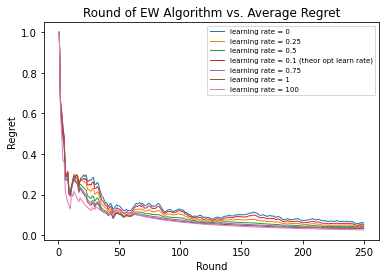

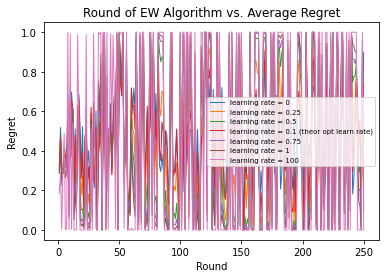

In [27]:
visualize_regret(avg_regret_per_round, rounds, learning_rates, 'Round of EW Algorithm vs. Average Regret', 'stock_plot.png')
visualize_regret(avg_regret_per_round_1, rounds, learning_rates, 'Round of EW Algorithm vs. Average Regret', 'stock_plot.png')